# Cell Thermal Calculations
_Author: Alif Aiman (alifaiman2010@gmail.com)_

The Python Notebook version of the thermal simulation done in Google Sheets. Almost everything is identical to the spreadsheet counterpart, except that in here Python has a slight edge at implementing _nonlinear Voc-SoE curve_, which helps in avoiding the negative square root error when trying to calculate for the electrical current.

Assumption(s) made in this model:
1. SoE = SoC

### 1. Initialization

Import neccessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from math import exp, pi,sqrt

Nonlinear regression model for Voc - SoE curve:

In [2]:
# prepare data
df = pd.read_csv("Voc-SoE.csv")
data = df.to_numpy()
x_train = data[:,1].reshape(-1,1)
y_train = data[:,0].ravel()

score = 0
while score < 0.999:
    # train model
    model_voc = MLPRegressor(hidden_layer_sizes = (1000,100,100), activation = 'tanh', solver = 'adam')
    model_voc.fit(x_train,y_train)

    # test score
    y_pred = model_voc.predict(x_train).reshape(-1,1)
    score = r2_score(y_train,y_pred)

print(f"score = {score}")

score = 0.9994742956854589


Constants & Initial Conditions:

In [3]:
mass = 0.048                    # cell mass [kg]
energy_initial = 9.24222*3600   # cell initial energy [J]
num_series = 112                # no. of cells in series
num_parallel = 6                # no. of cell arrays in parallel
radius = 0.009                  # cell radius [m]
height = 0.065                  # cell height [m]

conv_coeff = 5              # convection coefficient [W/m^2K]
timestep = 0.05             # [s]
T_amb = 25                  # ambient temp. [C]
num_laps = 22               # no. of laps in race

### 2. Data Extraction

Extract data from DCIR CSV:

In [4]:
df = pd.read_csv("DCIR.csv")
data_DCIR = df.to_numpy()
data_DCIR[:,1] = data_DCIR[:,1]*1e-3  # convert mOhm to Ohm
data_DCIR = np.vstack((data_DCIR, [0,0]))
np.set_printoptions(precision = 6)
print(data_DCIR)

[[1.000000e+02 2.652860e-02]
 [9.000000e+01 2.814592e-02]
 [8.000000e+01 2.920896e-02]
 [7.000000e+01 2.997857e-02]
 [6.000000e+01 3.058003e-02]
 [5.000000e+01 2.638074e-02]
 [4.000000e+01 2.635387e-02]
 [3.000000e+01 2.689120e-02]
 [2.000000e+01 2.826999e-02]
 [1.000000e+01 3.458533e-02]
 [0.000000e+00 0.000000e+00]]


In [5]:
print(data_DCIR[:,0])
diff_DCIR = data_DCIR[0,0] - data_DCIR[1,0]

[100.  90.  80.  70.  60.  50.  40.  30.  20.  10.   0.]


Extract data from power draw CSV:

In [6]:
df = pd.read_csv("Total_Power_Draw_20Hz.csv")
P_tot = df.to_numpy()   # accumulator power draw [W]
print(P_tot)

[[15616.25]
 [18801.25]
 [19938.75]
 ...
 [12350.  ]
 [12350.  ]
 [12837.5 ]]


Some early variable definitions (because some functions later down sort of freak out if I don't):

In [7]:
time_per_lap = timestep*len(P_tot)
print(time_per_lap)
end_time = time_per_lap*num_laps
time = np.arange(0,end_time + timestep,timestep)

P_tot_tiled = np.tile(P_tot, (num_laps,1))  # repeat P_tot as many times as the number of laps
P_tot_tiled = P_tot_tiled.ravel()
P_tot_tiled = np.hstack((0, P_tot_tiled))   # add 0 at the top of array as initial P (power off)
print(P_tot_tiled.shape)
print(time.shape)

P_cell = P_tot_tiled/(num_series*num_parallel)  # cell power draw [W]

69.95
(30779,)
(30779,)


### 3. Function Definitions

Define a function for calculating DCIR:

In [8]:
def DCIR(SoE):
    for i in range(len(data_DCIR[:,0])):
        if 0 <= data_DCIR[i,0] - SoE <= diff_DCIR:
            lower = i+1     # reversed because the array is ordered in reverse
            upper = i

    # print(data_DCIR[lower,0], data_DCIR[upper,0])
    # gradient
    m = (data_DCIR[upper,1] - data_DCIR[lower,1])/(data_DCIR[upper,0] - data_DCIR[lower,0])

    # intercept
    c = data_DCIR[upper,1] - m*data_DCIR[upper,0]

    return m*SoE + c

Define a function that predicts the Voc with the given SoE:

In [9]:
def Voc(SoE): 
    SoE = np.array([SoE])
    return model_voc.predict(SoE.reshape(1,-1))[0]

Define a function to calculate current:

In [10]:
def current(Voc,P,R):
    result = Voc/(2*R) - sqrt((Voc/(2*R))**2 - P/R)
    return result

Define a function that calculates temperature rise from energy consumption:

In [11]:
def dT1(I,R,Cp):
    Q_gen = (I**2)*R    # heat generated [W]
    Q = Q_gen*timestep  # heat energy [J]

    return Q/(mass*Cp)

Define a function that calculates temperature drop from cooling:

In [12]:
def dT2(T_prev, Cp):
    result = T_prev*(exp(-2*pi*radius*height*conv_coeff*timestep/(mass*Cp)) - 1) + T_amb*(1 - exp(-2*pi*radius*height*conv_coeff*timestep/(mass*Cp)))
    return result

Define a function to calculate specific heat capacity:

In [13]:
def sp_heat_capacity(T):
    return 899.02786 + 1.99582*T

Define a function that runs the entire simulation:

In [14]:
def run_sim():
    arr_length = len(time)

    I = np.zeros(arr_length)
    dE = np.zeros(arr_length)
    energy = np.zeros(arr_length)
    impedance = np.zeros(arr_length)
    SoE = np.zeros(arr_length)
    temp_rise = np.zeros(arr_length)
    temp_drop = np.zeros(arr_length)
    temp_net = np.zeros(arr_length)
    temp = np.zeros(arr_length)
    Cp = np.zeros(arr_length)
    lap = np.zeros(arr_length)
    open_circ_volt = np.zeros(arr_length)

    SoE[0] = 100.0
    impedance[0] = DCIR(SoE[0])
    temp[0] = T_amb
    Cp[0] = sp_heat_capacity(temp[0])
    energy[0] = energy_initial
    open_circ_volt[0] = Voc(SoE[0])

    for i in range(1,arr_length):

        lap[i] = int(1 + time[i]//time_per_lap)
        open_circ_volt[i] = Voc(SoE[i-1])
        dE[i] = P_cell[i]*timestep 
        energy[i] = energy[i-1] - dE[i] 
        SoE[i] = energy[i]/energy_initial*100
        impedance[i] = DCIR(SoE[i])
        I[i] = current(open_circ_volt[i], P_cell[i], impedance[i])
        Cp[i] = sp_heat_capacity(temp[i-1])
        temp_rise[i] = dT1(I[i], impedance[i], Cp[i])
        temp_drop[i] = dT2(temp[i-1], Cp[i])
        temp_net[i] = temp_rise[i] + temp_drop[i]
        temp[i] = temp[i-1] + temp_net[i]

        data = np.array([lap, time, P_cell, open_circ_volt, impedance, I, dE, energy, SoE, Cp, temp_rise, temp_drop, temp_net, temp]).T

    return data

### 4. Simulation

Run simulation:

In [15]:
data = run_sim()

Plot all data:

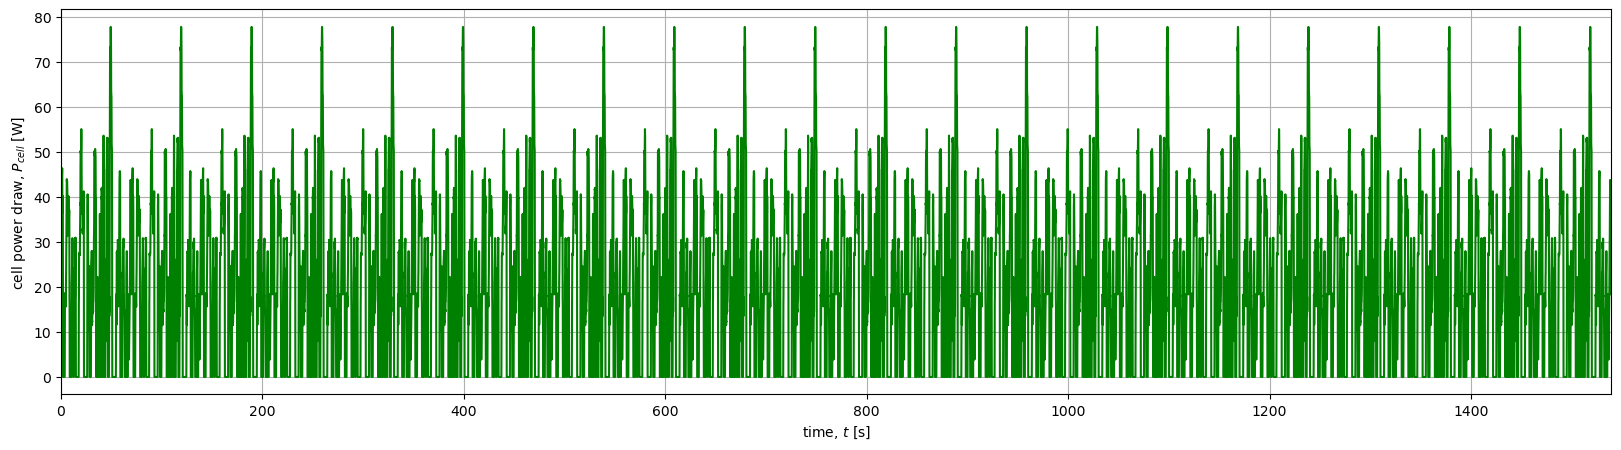

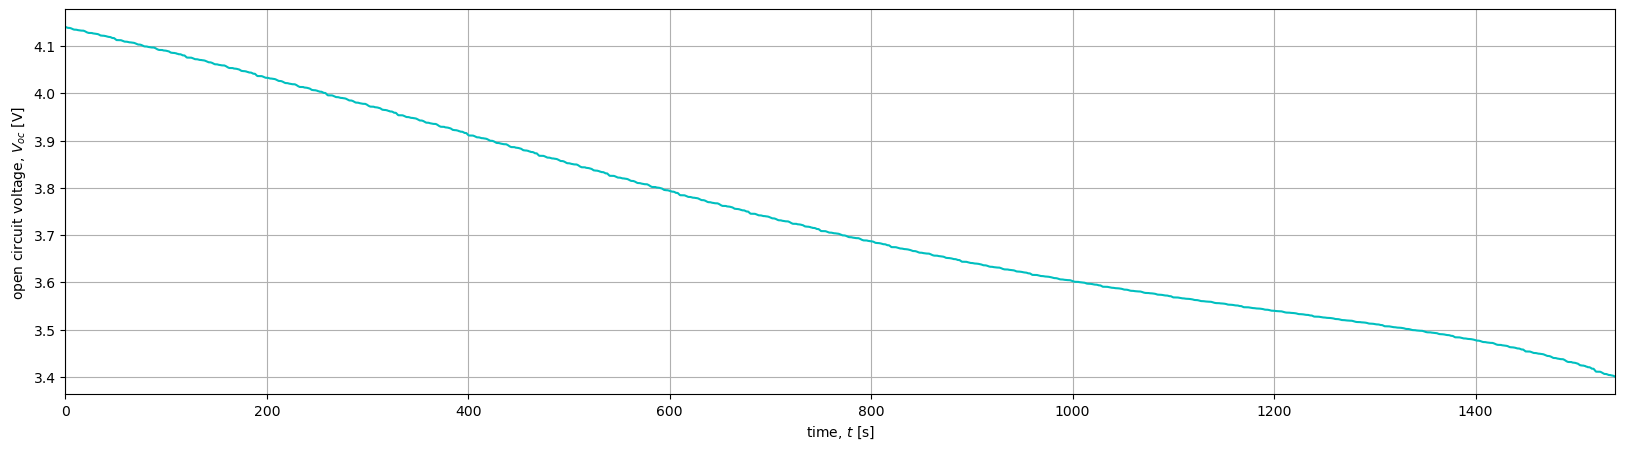

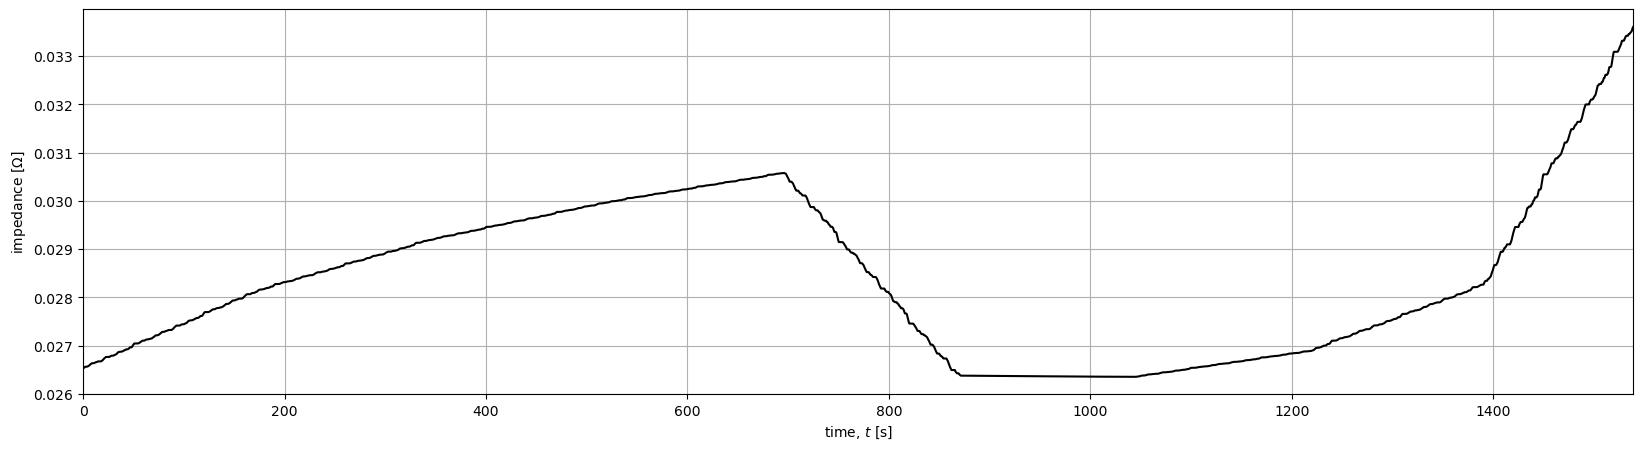

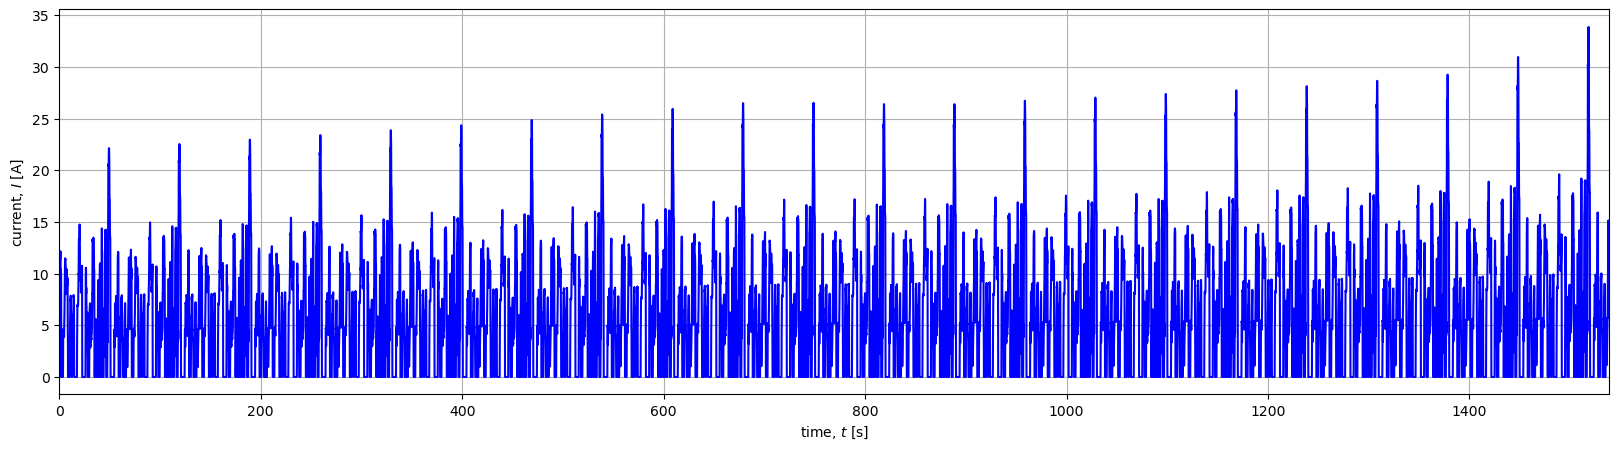

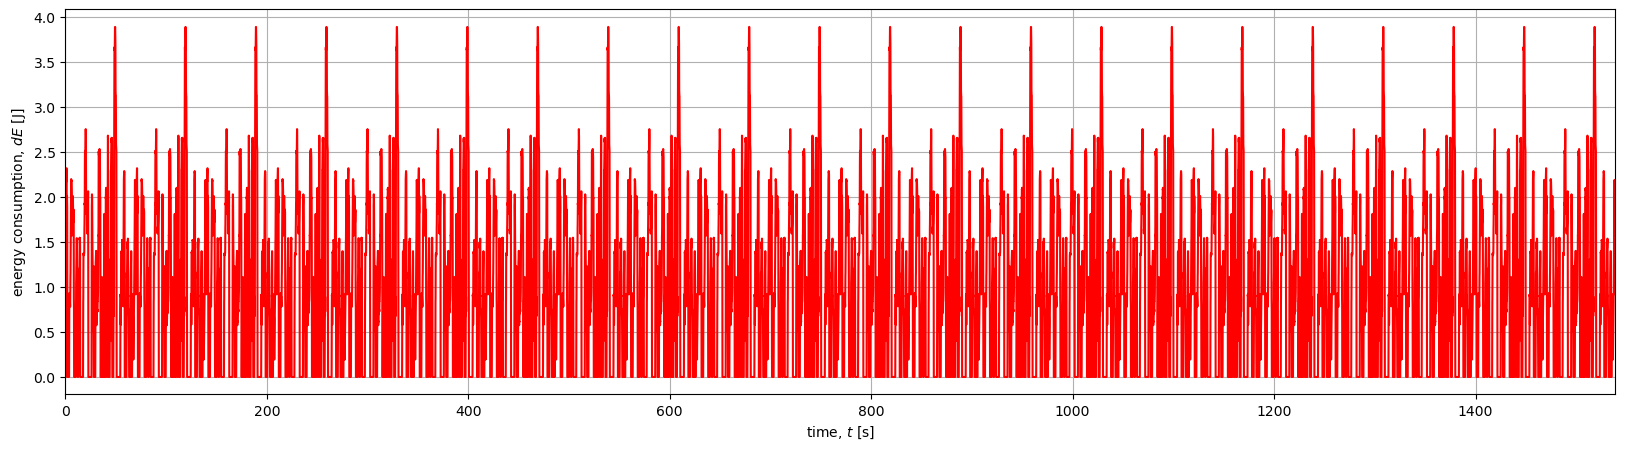

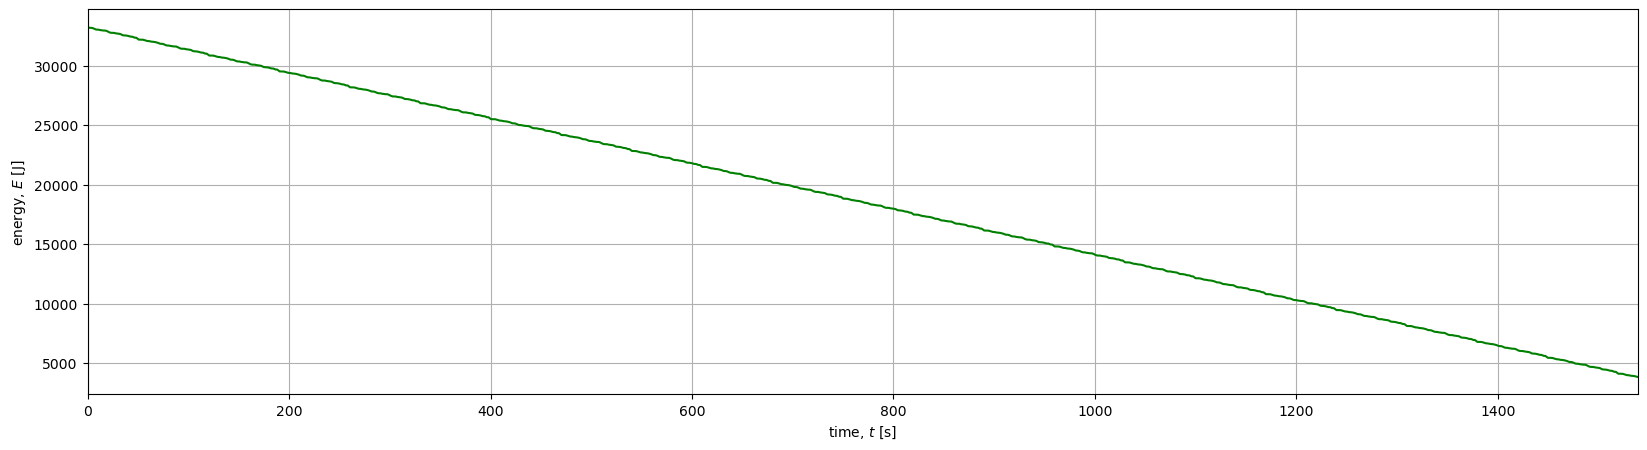

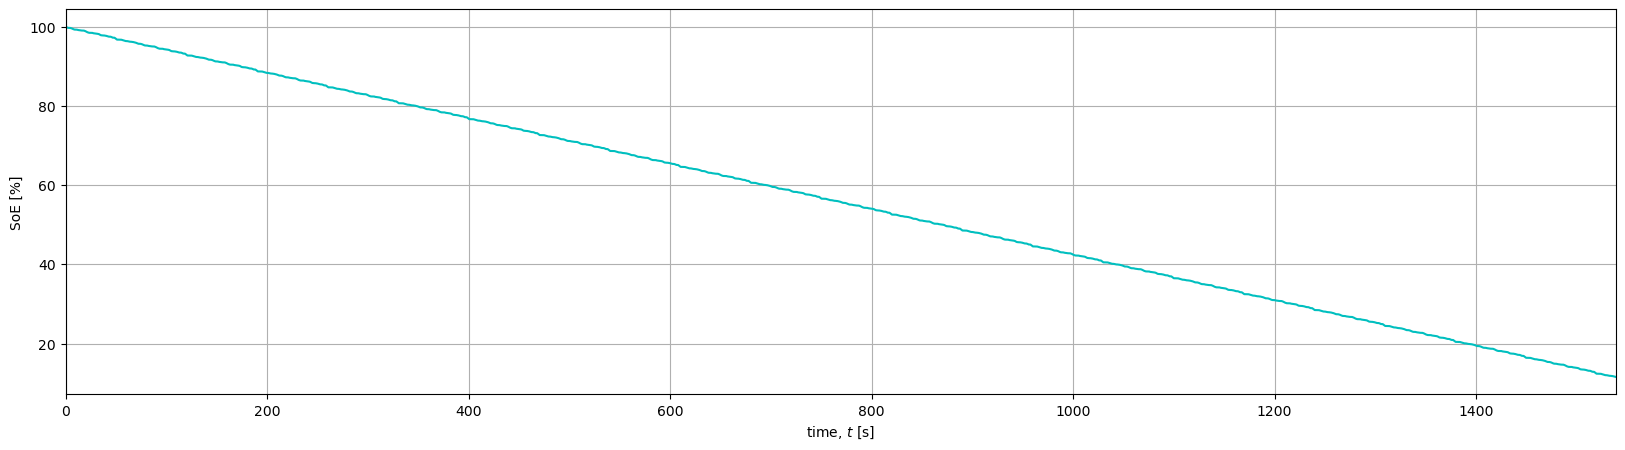

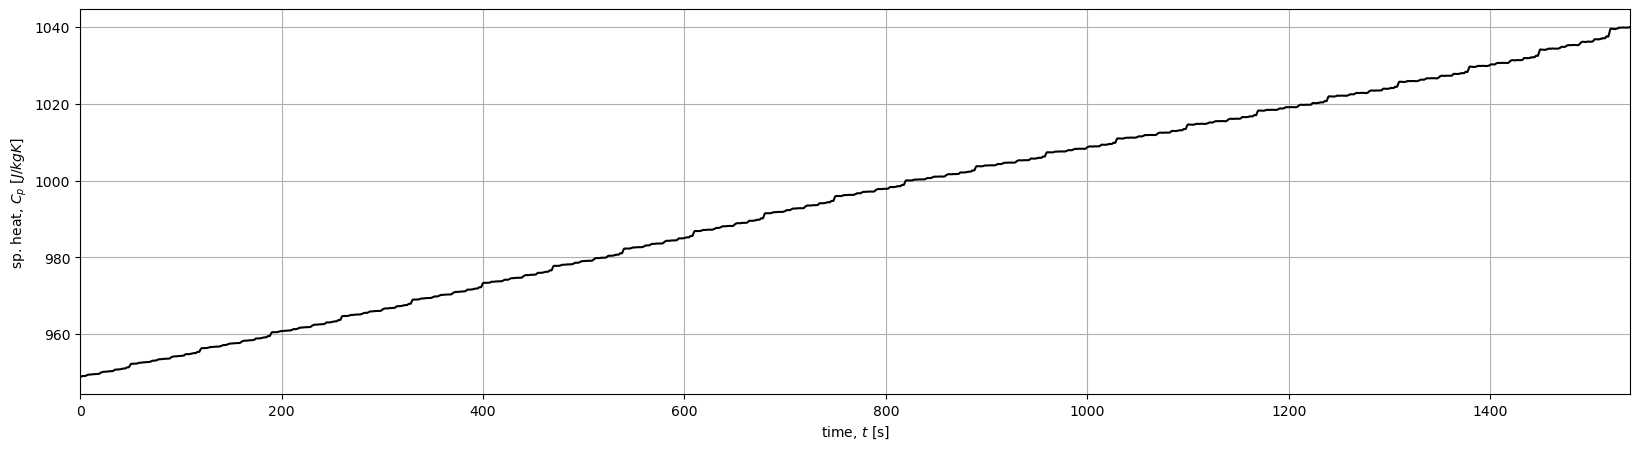

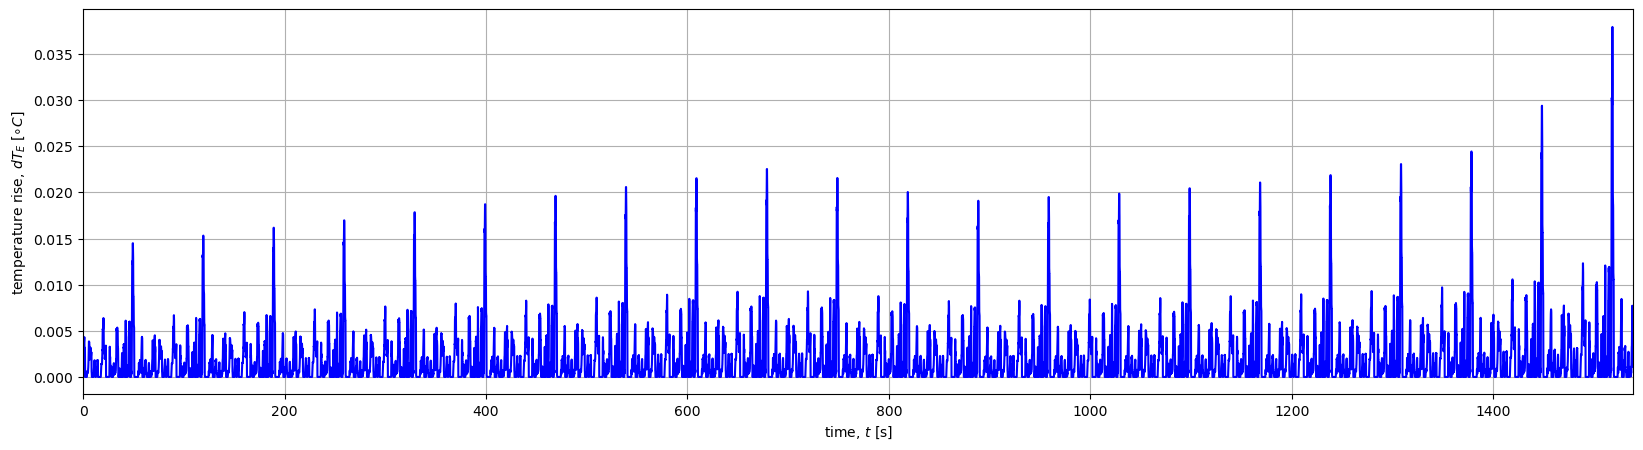

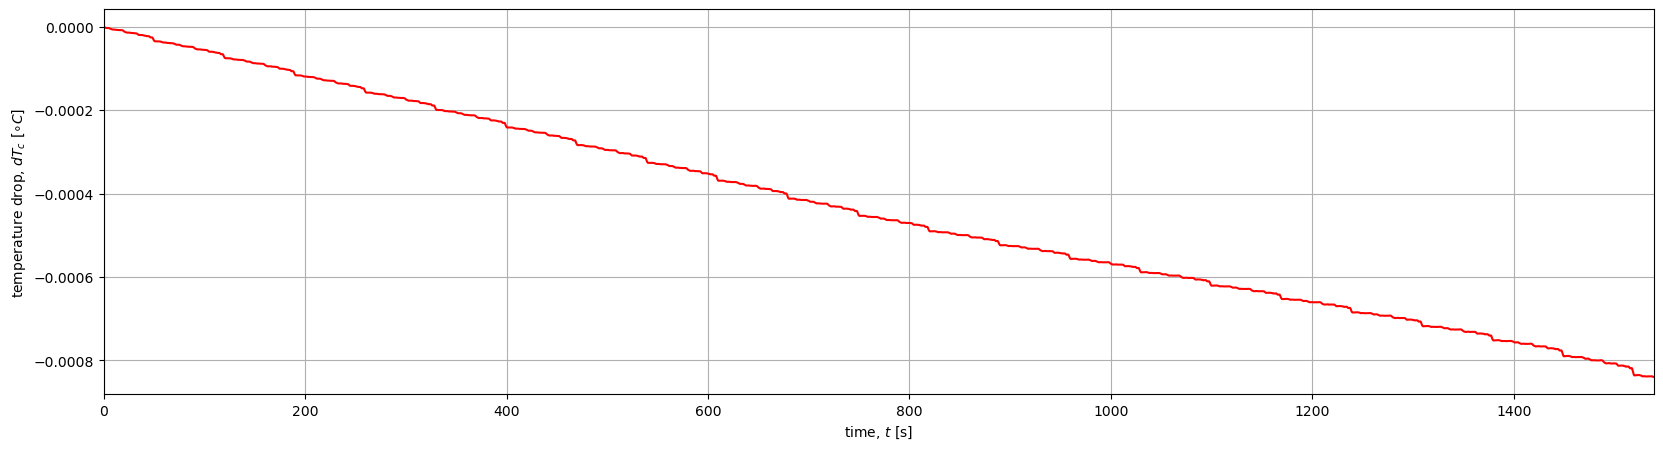

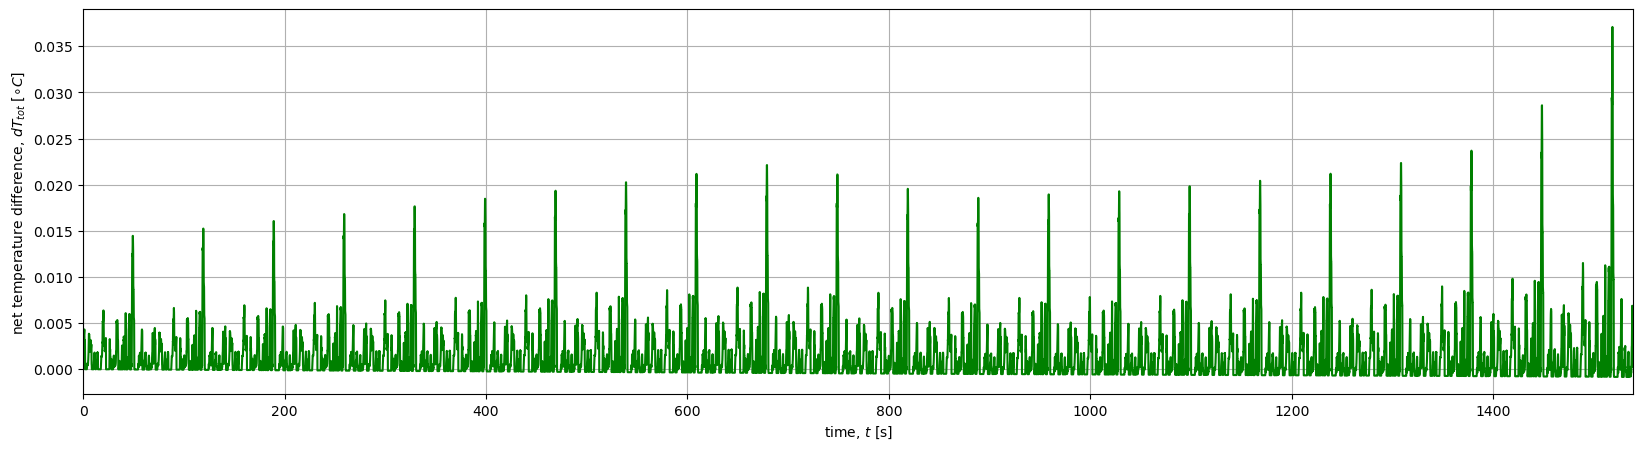

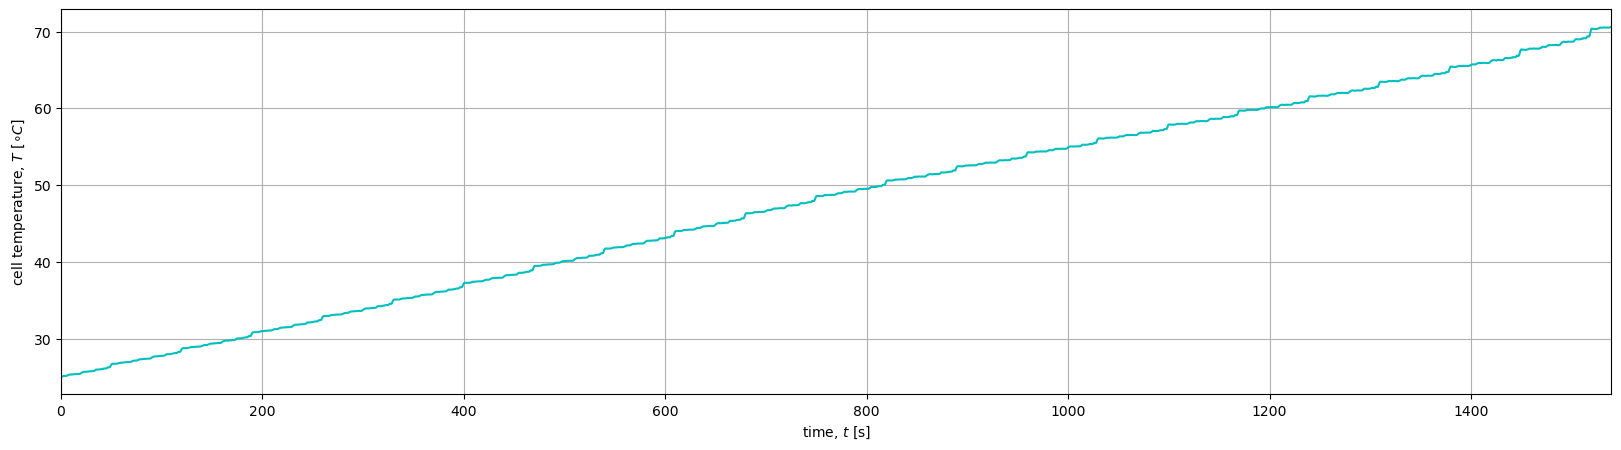

In [16]:
legends = ["lap", "time, $t$ [s]", "cell power draw, $P_{cell}$ [W]","open circuit voltage, $V_{oc}$ [V]", 
           "impedance [$\\Omega$]", "current, $I$ [A]","energy consumption, $dE$ [J]", "energy, $E$ [J]", 
           "SoE [%]", "sp. heat, $C_p$ [$J/kgK$]","temperature rise, $dT_E$ [$\\circ C$]", "temperature drop, $dT_c$ [$\\circ C$]",
           "net temperature difference, $dT_{tot}$ [$\\circ C$]", "cell temperature, $T$ [$\\circ C$]"]

colors = ["b", "r", "g", "c", "k"]

for i in range(2,data.shape[1]):
    color_to_choose = colors[int(i % len(colors))]
    plt.figure(figsize=(20,5))
    plt.plot(data[:,1], data[:,i], color_to_choose)
    plt.grid(1)
    plt.xlabel(legends[1])
    plt.ylabel(legends[i])
    plt.xlim(0,time[-1])
    plt.show()


Export data to CSV:

In [17]:
%%script False

df = pd.DataFrame(data)
df.columns = legends
df.to_csv("sim_data.csv", index = False)

Couldn't find program: 'False'


### 5. Testing

In [18]:
conv_coeff_test = np.arange(10,110,10)
print(conv_coeff_test)

[ 10  20  30  40  50  60  70  80  90 100]


In [19]:
def dT2_test(T_prev, Cp, conv_coeff):
    result = T_prev*(exp(-2*pi*radius*height*conv_coeff*timestep/(mass*Cp)) - 1) + T_amb*(1 - exp(-2*pi*radius*height*conv_coeff*timestep/(mass*Cp)))
    return result

In [20]:
def conv_sim_test(conv_coeff_test):
    arr_length = len(time)

    I = np.zeros(arr_length)
    dE = np.zeros(arr_length)
    energy = np.zeros(arr_length)
    impedance = np.zeros(arr_length)
    SoE = np.zeros(arr_length)
    temp_rise = np.zeros(arr_length)
    temp_drop = np.zeros(arr_length)
    temp_net = np.zeros(arr_length)
    temp = np.zeros(arr_length)
    Cp = np.zeros(arr_length)
    lap = np.zeros(arr_length)
    open_circ_volt = np.zeros(arr_length)

    SoE[0] = 100.0
    impedance[0] = DCIR(SoE[0])
    temp[0] = T_amb
    Cp[0] = sp_heat_capacity(temp[0])
    energy[0] = energy_initial
    open_circ_volt[0] = Voc(SoE[0])

    for i in range(1,arr_length):

        lap[i] = int(1 + time[i]//time_per_lap)
        open_circ_volt[i] = Voc(SoE[i-1])
        dE[i] = P_cell[i]*timestep 
        energy[i] = energy[i-1] - dE[i] 
        SoE[i] = energy[i]/energy_initial*100
        impedance[i] = DCIR(SoE[i])
        I[i] = current(open_circ_volt[i], P_cell[i], impedance[i])
        Cp[i] = sp_heat_capacity(temp[i-1])
        temp_rise[i] = dT1(I[i], impedance[i], Cp[i])
        temp_drop[i] = dT2_test(temp[i-1], Cp[i], conv_coeff_test)
        temp_net[i] = temp_rise[i] + temp_drop[i]
        temp[i] = temp[i-1] + temp_net[i]


    return temp.T

In [21]:
temps = np.zeros((len(time), len(conv_coeff_test)))

for i in range(len(conv_coeff_test)):
    temps[:,i] = conv_sim_test(conv_coeff_test[i])

KeyboardInterrupt: 

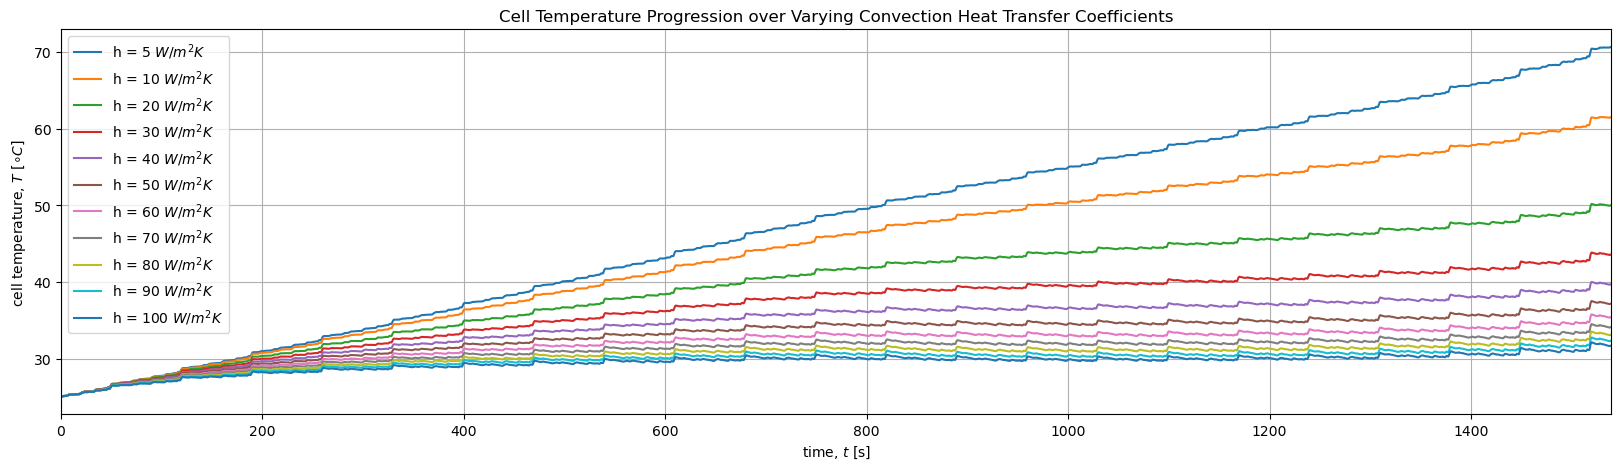

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data[:,1], data[:,-1], label = "h = 5 $W/m^{2}K$")
plt.xlabel("time, $t$ [s]")
plt.ylabel("cell temperature, $T$ [$\\circ C$]")
plt.xlim(0,time[-1])
plt.grid(1)

for i in range(temps.shape[1]):
    plt.plot(data[:,1], temps[:,i], label = f"h = {conv_coeff_test[i]} $W/m^{2}K$")

plt.title("Cell Temperature Progression over Varying Convection Heat Transfer Coefficients")
plt.legend()
plt.show()
    